In [1]:
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = '682 Project'
assert FOLDERNAME is not None

import sys
sys.path.append('/content/drive/Sharedrives/{}'.format(FOLDERNAME))
%cd /content/drive/Shareddrives/$FOLDERNAME

Mounted at /content/drive
/content/drive/Shareddrives/682 Project


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50, ResNet50_Weights
import torch.optim as optimizer
import numpy as np
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt

## Transform

1. Random Cropping with size ratio between .08 and 1.0 with resizing. RandomResizedCrop(32, scale=(0.08, 0.1)) in PyTorch.
2. Random horizontal flip with probability 0.5.
3. Color jittering of brightness, contrast, saturation and hue, with probability 0.8.
ColorJitter(0.4, 0.4, 0.2, 0.1) in PyTorch.
4. Grayscale with probability 0.2
5. Gaussian blur with probability 0.5 and kernel size 23. (Do we keep the sample kernel size for cifar-10?)
6. Solarization with probability 0.1.
7. Color normalization with mean (0.485, 0.456, 0.406) and standard deviation (0.229, 0.224,
0.225).

https://pytorch.org/vision/main/transforms.html

GAUSSIAN_BLUR:
https://pytorch.org/vision/main/generated/torchvision.transforms.GaussianBlur.html#torchvision.transforms.GaussianBlur
    Inputs:
    - kernel_size (int or sequence) – Size of the Gaussian kernel.
    - sigma (float or tuple of python:float (min, max)) – Standard deviation to be used for creating kernel to perform blurring.
    If float, sigma is fixed. If it is tuple of float (min, max), sigma is chosen uniformly at random to lie in the given range.



In [3]:
kernel_size=23
sigma=(0.1, 2.0)
solarize_threshold = .5
transform = transforms.Compose([
    transforms.RandomResizedCrop(size=(32, 32), antialias=True),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(0.4, 0.4, 0.2, 0.1),
    transforms.RandomGrayscale(.2), # [BETA] Randomly convert image or videos to grayscale with a probability of p (default 0.1).
    transforms.GaussianBlur(kernel_size , sigma), # [BETA] Blurs image with randomly chosen Gaussian blur.
    transforms.RandomSolarize(solarize_threshold, p = .1),
    #transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


## VicReg Loss Function

In [4]:
lamb = 25 # invar loss weight
mu = 25 # var loss weight
nu = 1 # covar loss weight

In [5]:
def calculate_loss(z, z_prime):
    """Calculate the loss function.

    The following is heavily based on the psuedo code provided on page 13 of https://arxiv.org/pdf/2105.04906.pdf

    Need to calculate 3 things:

    1. Variance

    2. Invariance

    3. Covariance

    Args:
        z (_type_): batch of images transformed, encodeded, projected
        z_prime (_type_): batch of images transformed, encodeded, projected
    """

    # 1. Variance Loss
    var_epsilon = 1e-4
    std_z = torch.sqrt(z.var(dim=0) + var_epsilon)
    std_z_prime = torch.sqrt(z_prime.var(dim=0) + var_epsilon)
    std_loss = torch.mean(F.relu(1 - std_z)) + torch.mean(F.relu(1 - std_z_prime))


    # 2. Invariance Loss (Just MSE Loss)
    invar_loss = F.mse_loss(z, z_prime)

    # 3. Covariance Loss

    N , D = z.shape
    z = z - z.mean(dim=0)
    z_prime = z_prime - z_prime.mean(dim=0)
    cov_z = (z.T @ z) / (N - 1)
    cov_z_prime = (z_prime.T @ z_prime) / (N - 1)

    cov_z = cov_z.pow(2)
    cov_z_prime = cov_z_prime.pow(2)

    loss_c_a = (cov_z.sum() - cov_z.diagonal().sum()) / D
    loss_c_b = (cov_z_prime.sum() - cov_z_prime.diagonal().sum()) / D

    loss_cov = loss_c_a + loss_c_b

    loss = lamb * invar_loss + mu * std_loss + nu * loss_cov

    return loss

In [6]:
class SameTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, x):
        return self.transform(x), self.transform(x)

In [8]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 256
default_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download = True, transform = default_transform)

split_ratio = 0.8
total_size = len(trainset)
train_size = int(split_ratio * total_size)
valid_size = total_size - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(trainset, [train_size, valid_size])

second_split = 0.01
total_size = len(train_dataset)
labeled_size = int(second_split * total_size)
discard_size = total_size - labeled_size
labeled_dataset, discard_dataset = torch.utils.data.random_split(train_dataset, [labeled_size, discard_size])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
labelloader = torch.utils.data.DataLoader(labeled_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform = default_transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=8)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


In [9]:
len(train_dataset), len(labeled_dataset)

(40000, 400)

## Encoder

- Standard ResNet - 50 Backbone

In [10]:
import torchvision.models as models

class Encoder(nn.Module):
    def __init__(self, output_units=512):
        super(Encoder, self).__init__()
        # Load pre-trained ResNet-50 model from torchvision
        resnet = models.resnet50(pretrained=True)

        # Remove the fully connected layers at the end
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

        # Add global average pooling layer
        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))

        # Output projection layer
        self.projection_layer = nn.Linear(2048, output_units)

    def forward(self, x):
        # Forward pass through ResNet-50 backbone
        x = self.resnet(x)

        # Global average pooling
        x = self.global_avg_pooling(x)
        x = x.view(x.size(0), -1)

        # Projection layer
        x = self.projection_layer(x)

        return x

In [11]:

# Create an instance of the Encoder with 512 output units
encoder = Encoder(output_units=512)

# Test the encoder with a random input
random_input = torch.randn((1, 3, 224, 224))  # Assuming input image size is 224x224
output = encoder(random_input)

print("Output shape:", output.shape)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 100MB/s] 


Output shape: torch.Size([1, 512])


In [12]:
class Expander(nn.Module):
    def __init__(self, input_size, output_size=8192):
        """

        expander hφ:
        Composed of two fully-connected layers with batch normalization and ReLU,
        and a third linear layer. The sizes of all 3 layers were set to 8192

        Args:
            input_size (int): cifar vector size
            output_size (int): output vector size, also size of intermediate linear layers.
        """
        super(Expander, self).__init__()

          # Flatten layer
        self.flatten = nn.Flatten()
        # First fully-connected layer
        self.fc1 = nn.Linear(input_size, output_size)
        self.bn1 = nn.BatchNorm1d(output_size)
        self.relu1 = nn.ReLU()

        # Second fully-connected layer
        self.fc2 = nn.Linear(output_size, output_size)
        self.bn2 = nn.BatchNorm1d(output_size)
        self.relu2 = nn.ReLU()

        # Third linear layer
        self.fc3 = nn.Linear(output_size, output_size)

    def forward(self, x):
        # Forward pass through the layers
        x = self.flatten(x)
        x = self.fc1(x)
        if x.size(0) > 1:
            x = self.bn1(x)

        x = self.relu1(x)

        x = self.fc2(x)

        if x.size(0) > 1:
            x = self.bn2(x)

        x = self.relu2(x)

        x = self.fc3(x)

        return x

In [13]:
expander = Expander(input_size=512, output_size=2048)
expanded_output = expander(output)
print("Expanded output shape:", expanded_output.shape)

Expanded output shape: torch.Size([1, 2048])


In [14]:
class VICReg(nn.Module):

    def __init__(self, encoder_size, expander_size):

        super().__init__()
        self.encoder = Encoder(encoder_size)
        self.expander = Expander(encoder_size, expander_size)

    def forward(self, x):
        x = self.encoder(x)
        x = self.expander(x)

        return x

In [15]:
from torch.optim.lr_scheduler import StepLR

train_epochs = 50

# Hyper parameters
learning_rate_decay = 10e-6
batch_size = 256
encoder_size = 2048
expander_size = 4096
base_lr = .01

#encoder = ResNet50_Weights.DEFAULT.transforms()
#expander = Expander(encoder_size, expander_size)

lr = (batch_size / 256) * base_lr

model = VICReg(encoder_size, expander_size)
model.to(device)
params = model.parameters()
optimiz = optimizer.SGD(params, lr = lr, weight_decay= learning_rate_decay)

scheduler = StepLR(optimiz, step_size=20, gamma=0.1)

In [ ]:
def train_loop(model, optimizer, trainloader, criterion, device):
  tk0 = tqdm(trainloader)
  train_loss = []

  for batch, _ in tk0:

    model.train()

    batch = batch.to(device)
    x = transform(batch)
    x1 = transform(batch)

    fx = model(x)
    fx1 = model(x1)
    loss = criterion(fx, fx1)
    #print(loss)
    train_loss.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  return train_loss


for epoch in range(train_epochs):
  train_loss = train_loop(model, optimiz, trainloader, calculate_loss, device)
  scheduler.step()
  print(epoch)
  print(np.mean(train_loss))


# Save Model

In [ ]:
torch.save(model.state_dict(), 'vigreg512-1024.pth')

# Load Model

In [18]:
state_dict = torch.load('vigreg1024-2048.pth', map_location=torch.device(device))

encoder_size, expander_size = 1024, 2048
vicreg = VICReg(encoder_size, expander_size)
vicreg.to(device)

vicreg.load_state_dict(state_dict)

<All keys matched successfully>

# Tune Hyper Params


In [19]:
def train(vicreg, model, epochs):
    plot_loss = []
    plot_trn_acc = []
    for epoch in range(epochs):

      running_loss = 0.0
      #vicreg.eval()

      for i, data in enumerate(labelloader, 0):
        correct = 0
        total = 0
        vicreg.train()
        model.train()
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        vicreg_optimizer.zero_grad()

        inputs = vicreg(inputs)
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        vicreg_optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

      print(f'Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(trainloader)}')
      plot_loss.append(running_loss / len(trainloader))
      plot_trn_acc.append(correct / total)
    return plot_loss, plot_trn_acc

def validate(vicreg, model):
    correct = 0
    total = 0

    vicreg.eval()
    model.eval()
    with torch.no_grad():
        for data in validloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            inputs = vicreg(inputs)
            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = (100 * correct / total)
    return (acc)

In [20]:
class NetFC(nn.Module):
  def __init__(self, embedded_dem):
    super().__init__()
    self.fc1 = nn.Linear(embedded_dem, embedded_dem // 2)
    self.fc2 = nn.Linear(embedded_dem // 2, embedded_dem // 4)
    self.fc3 = nn.Linear(embedded_dem // 4, 10)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.softmax(self.fc3(x))
    return x

In [ ]:
from itertools import product
import torch
import torch.nn as nn
import torch.optim as optim


learning_rate = 1e-2
criterion = nn.CrossEntropyLoss()

model = NetFC(expander_size).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=.9)
vicreg = VICReg(encoder_size, expander_size).to(device) # RESET VICREG after every run
vicreg.load_state_dict(state_dict)
vicreg_optimizer = torch.optim.SGD(vicreg.parameters(), lr = learning_rate , momentum = .9)
# optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)

epochs = 50
plt_loss, plt_trn_acc = train(vicreg, model, epochs)
valid_acc = validate(vicreg, model)
print(f"valid_acc={valid_acc}")


In [ ]:
total, correct = 0, 0

with torch.no_grad():
  for inputs, labels in testloader:
    inputs, labels = inputs.to(device), labels.to(device)

    inputs = vicreg(inputs)
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {100 * accuracy:.2f}%')

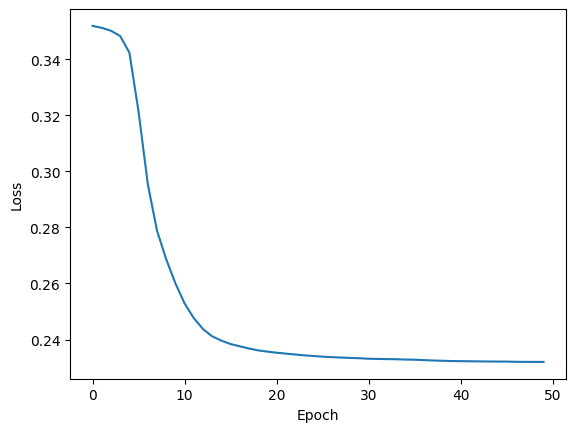

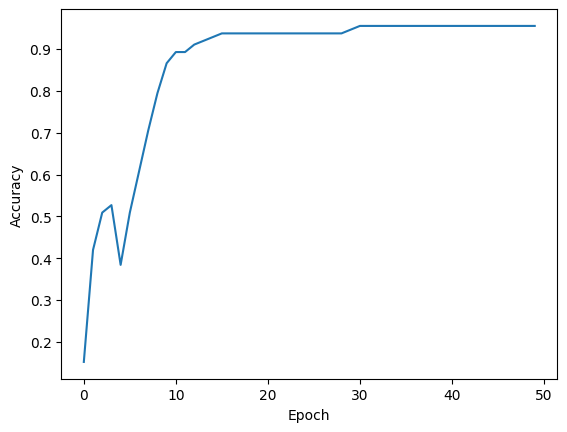

In [ ]:
#Plot Training Loss
x = [i for i in range(epochs)]
plt.plot(x, plt_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

#Plot Training Accuracy
plt.plot(x, plt_trn_acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()